In [1]:
import cv2
import glob
import numpy as np
print("OpenCV version :  {0}".format(cv2.__version__))

OpenCV version :  4.2.0


# Step 1 Load the images and camera parameters.

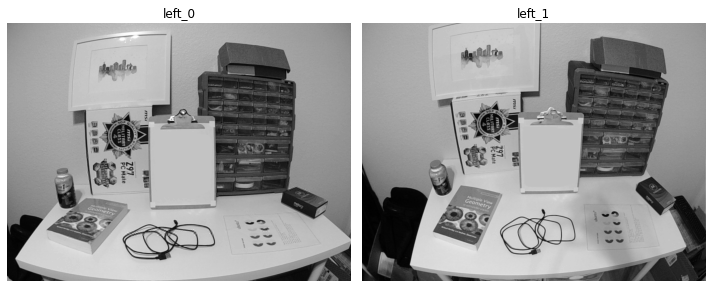

In [2]:
# 0 for grayscale
left_ = [cv2.imread(image, 0) for image in sorted(glob.glob("../../images/task_7/left_*.png"))]
right_ = [cv2.imread(image, 0) for image in sorted(glob.glob("../../images/task_7/right_*.png"))]

import matplotlib.pyplot as plt
def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    if(nrows > 1 or ncols > 1):
        for ind,title in enumerate(figures):
            axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
            axeslist.ravel()[ind].set_title(title)
            axeslist.ravel()[ind].set_axis_off()
        plt.tight_layout() # optional
    else:
        for ind,title in enumerate(figures):
            axeslist.imshow(figures[title], cmap=plt.gray())
            axeslist.set_title(title)
            axeslist.set_axis_off()
            

# plot_figures({'left_0': left_[0], 'left_1': left_[1]}, 1, 2)

## Camera parameter matrices

In [3]:
left_intrinsic = np.array([[423.27381306, 0, 341.34626532],
                           [0, 421.27401756, 269.28542111],
                           [0, 0, 1]])

right_intrinsic = np.array([[420.91160482, 0, 352.16135589],
                            [0, 418.72245958, 264.50726699],
                            [0, 0, 1]])

distCoeffs_left = np.array([-0.43394157423038077, 0.26707717557547866,
                             -0.00031144347020293427, 0.0005638938101488364,
                             -0.10970452266148858])
distCoeffs_right = np.array([-0.4145817681176909, 0.19961273246897668,
                             -0.00014832091141656534, -0.0013686760437966467,
                             -0.05113584625015141])

# Step 2 Detect, match, and associate features on the image pair.

## First, undistort the images

In [4]:
def undistortImage(img, mtx, distCoeffs):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,distCoeffs,(w,h),0,(w,h))   # warp=0

#     dst = cv2.undistort(img, mtx, distCoeffs, None, newcameramtx)

    mapx, mapy = cv2.initUndistortRectifyMap(left_intrinsic, distCoeffs_left, None, newcameramtx, (w,h), 5)
    dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

    # crop the image
    x,y,w,h = roi
    return dst[y:y+h, x:x+w]

for i in range(len(left_)):
    left_[i] = undistortImage(left_[i], left_intrinsic, distCoeffs_left)

for i in range(len(right_)):
    right_[i] = undistortImage(right_[i], right_intrinsic, distCoeffs_right)
    
# plot_figures({'left_0': left_[0], 'left_1': left_[1]}, 1, 2)

## Get ORB features

In [5]:
left_0 = left_[0].copy()
left_1 = left_[1].copy()

# Initiate STAR detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp_0 = orb.detect(left_0,None)
kp_1 = orb.detect(left_1,None)

# compute the descriptors with ORB
kp_0, des_0 = orb.compute(left_0, kp_0)
kp_1, des_1 = orb.compute(left_1, kp_1)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des_0,des_1)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

len(matches)

210


# Step 3 Calculate the essential matrix between the image pair.

In [6]:
# select points to evaluate the fundamental matrix
pts1 = []
pts2 = []

# get the 20 best points
for match in matches[:]:
    pts1.append(kp_0[match.queryIdx].pt)
    pts2.append(kp_1[match.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

In [7]:
# cv2.findEssentialMat?

In [8]:
# evaluate the essential Matrix
E, mask0 = cv2.findEssentialMat(pts1, pts2, left_intrinsic)    # pass in the camera matrix since we undistorted the images
E = np.mat(E)
print('Essential Matrix:\n',E)

Essential Matrix:
 [[ 0.01766897  0.0888293  -0.69735246]
 [-0.31757476  0.03375754  0.06299089]
 [ 0.62480722 -0.08763292  0.03836621]]


#### remove outliers

In [9]:
inlier_matches = []

for i, t in enumerate(mask0):
    if t[0]:   # if we have an inlier
        inlier_matches.append(matches[i])
        
pts1 = []
pts2 = []

for i, match in enumerate(inlier_matches[:]):
    pts1.append(kp_0[match.queryIdx].pt)
    pts2.append(kp_1[match.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)
pts1.shape

(138, 2)

In [10]:
img = cv2.drawMatches(left_0,kp_0,left_1,kp_1,inlier_matches[:], None,flags=2)

# plot_figures({'inliers between left_0 and left_1':img})
# cv2.imwrite('../../output/task_7/inliers between left_0 and left_1.png', img)

# Step 4: Determine relative camera pose

In [11]:
number_of_inlier_pts, R, t, mask = cv2.recoverPose(E,pts1,pts2,left_intrinsic)
print('left_1 camera pose:')
print('R:\n',R)
print('t:\n',t)
number_of_inlier_pts, R, t, mask

left_1 camera pose:
R:
 [[ 0.99936264 -0.02833584  0.02171163]
 [ 0.03396058  0.94208255 -0.33365722]
 [-0.01099969  0.3341819   0.94244441]]
t:
 [[0.1048495 ]
 [0.8877374 ]
 [0.44825092]]


(138,
 array([[ 0.99936264, -0.02833584,  0.02171163],
        [ 0.03396058,  0.94208255, -0.33365722],
        [-0.01099969,  0.3341819 ,  0.94244441]]),
 array([[0.1048495 ],
        [0.8877374 ],
        [0.44825092]]),
 array([[255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255],
        [255

# Step 5: Check the reconstruction results
Use the overloaded function [recoverPose](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga2ee9f187170acece29c5172c2175e7ae)  to get the 3D points

In [12]:
distanceThresh = 20
number_of_inlier_pts, R, t, mask, triangulatedPoints = cv2.recoverPose(E,pts1,pts2,left_intrinsic,distanceThresh,R,t,mask)

In [13]:
# convert to cartesian coordinates
points3D = []
points3D.append(triangulatedPoints[0]/triangulatedPoints[3])
points3D.append(triangulatedPoints[1]/triangulatedPoints[3])
points3D.append(triangulatedPoints[2]/triangulatedPoints[3])
points3D = np.array(points3D)
points3D

array([[-9.12099845e-01, -1.21276123e+00, -9.18555679e-01,
        -9.27866040e-01, -7.30946007e-01, -7.10852909e-01,
        -7.93571012e-01, -9.30612308e-01, -9.40855193e-01,
        -7.92785688e-01, -9.44233402e-01, -9.31781340e-01,
        -1.27778744e+00, -1.24795655e+00, -1.18683714e+00,
        -7.47309903e-01, -1.18165479e+00, -3.43063335e-01,
        -9.43777485e-01, -1.22670133e+00, -7.94794285e-01,
        -9.49385743e-01, -1.21631701e+00, -1.25525224e+00,
        -9.39791481e-01, -9.26501975e-01, -9.15429307e-01,
        -1.21461389e+00, -1.27021254e+00, -9.41056017e-01,
        -1.19691284e+00, -1.33320461e+00, -1.25139724e+00,
        -1.50746593e+00, -1.25212062e+00, -1.24339000e+00,
        -7.15128428e-01, -1.27509382e+00, -9.23080839e-01,
        -9.22072179e-01, -9.24516575e-01, -9.04181951e-01,
        -1.00688294e+00, -9.46592911e-01, -9.73626296e-01,
        -9.06159081e-01, -9.39645734e-01, -1.53654360e+00,
        -7.28476642e-01, -9.50205906e-01, -9.90433131e-0

In [14]:
points3D.shape

(3, 138)

## Functions

In [15]:
import math
from pyquaternion import Quaternion

def create3DPlot(withAxes=True, autoscale=False, bound=5):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    
    if not autoscale:
        ax.autoscale(False)
        ax.set_xbound(-bound,bound)
        ax.set_ybound(-bound,bound)
        ax.set_zbound(-bound,bound)
        
    if withAxes:
        # x axis is red
        x_line = np.linspace(0,4,100)
        y_line = x_line*0
        z_line = y_line
        ax.plot3D(x_line, y_line, z_line,'red')

        # y axis is green
        y_line = np.linspace(0,4,100)
        x_line = y_line*0
        z_line = x_line
        ax.plot3D(x_line, y_line, z_line,'green')

        # z axis is blue
        z_line = np.linspace(0,4,100)
        y_line = z_line*0
        x_line = y_line
        ax.plot3D(x_line, y_line, z_line,'blue')
        
    return ax

def getCameraPose(points, R, trans_vec, trans_multiplier=1.5):
    # takes in a list of any amount of points and rotates them
    def rotatePoints(points, R):
        points = points.transpose()
        rotated_points = []
        for point in points:
            rotated_points.append(np.array(point).dot(R))
            
        return np.array(rotated_points).transpose()
    
    def transposePoints(points, trans_vec):
        points = points.transpose()

        for i in range(points.shape[0]):
            points[i] = np.add(points[i], trans_vec.flatten())

        return points.transpose()
    
    points = rotatePoints(points, R)
    points = transposePoints(points, trans_vec*trans_multiplier)
    
    return points

def drawCameraPose(cameraPoints, ax, index='0'):
    # this function draws black lines between cameraPoints
    # to make a camera looking thing 
    
    # 0 to 1 .all others
    for i in range(5):
        x_line = np.linspace(cameraPoints[0][0],cameraPoints[0][i],50)
        y_line = np.linspace(cameraPoints[1][0],cameraPoints[1][i],50)
        z_line = np.linspace(cameraPoints[2][0],cameraPoints[2][i],50)
        ax.plot3D(x_line, y_line, z_line,'black')
        
    for i in range(1,4):
        x_line = np.linspace(cameraPoints[0][i],cameraPoints[0][i+1],50)
        y_line = np.linspace(cameraPoints[1][i],cameraPoints[1][i+1],50)
        z_line = np.linspace(cameraPoints[2][i],cameraPoints[2][i+1],50)
        ax.plot3D(x_line, y_line, z_line,'black')
    
    x_line = np.linspace(cameraPoints[0][4],cameraPoints[0][1],50)
    y_line = np.linspace(cameraPoints[1][4],cameraPoints[1][1],50)
    z_line = np.linspace(cameraPoints[2][4],cameraPoints[2][1],50)
    
    # write the label
#     ax.scatter3D(cameraPoints[0][0], cameraPoints[1][0], cameraPoints[2][0], c='red');
    ax.text(cameraPoints[0][0], cameraPoints[1][0], cameraPoints[2][0], index, color='red')
    
    ax.plot3D(x_line, y_line, z_line,'black')

## Plot 3D Points

In [16]:
# %matplotlib inline

In [17]:
# %matplotlib qt

### solvePnP 
We need to get the pose of the first camera.

In [18]:
retval, rot_vec, trans_vec = cv2.solvePnP(points3D.transpose(), pts2, left_intrinsic, distCoeffs_left)
retval

True

In [19]:
print('left_0 camera pose:')
print('R:\n',cv2.Rodrigues(rot_vec)[0])
print('t:\n',t)

left_0 camera pose:
R:
 [[ 0.99950979 -0.02058908  0.02358544]
 [ 0.02676288  0.95280283 -0.30240788]
 [-0.01624597  0.30289085  0.95288677]]
t:
 [[0.1048495 ]
 [0.8877374 ]
 [0.44825092]]


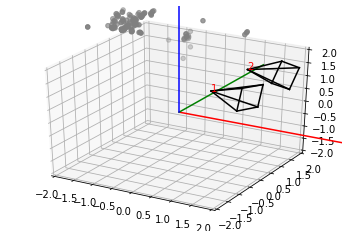

In [20]:
# draw a camera at the origin
x_points = [0, 1, 1, 1, 1]
y_points = [0, 0.5,-0.5,-0.5, 0.5]
z_points = [0, 0.4, 0.4,-0.4,-0.4]
og_cameraPoints = np.array([x_points,y_points,z_points])
ax = create3DPlot(bound = 2)

cameraPoints = getCameraPose(og_cameraPoints.copy(),cv2.Rodrigues(rot_vec)[0],trans_vec)  # rotate and translate those camera points
cameraPoints2 = getCameraPose(cameraPoints.copy(),R,t)  # rotate and translate those camera points

# drawCameraPose(og_cameraPoints, ax, '0')
drawCameraPose(cameraPoints, ax, '1')   # draw them in 3D
drawCameraPose(cameraPoints2, ax, '2')   # draw them in 3D

ax.scatter3D(points3D[0],points3D[1],points3D[2], c='grey')

plt.show()

#### Plot camera using Duo's results of left_0.png

In [21]:
# # draw a camera at the origin
# x_points = [0, 1, 1, 1, 1]
# y_points = [0, 0.5,-0.5,-0.5, 0.5]
# z_points = [0, 0.4, 0.4,-0.4,-0.4]
# og_cameraPoints = np.array([x_points,y_points,z_points])
# ax = create3DPlot()

# rot_vec = np.array([[0.99504195, -0.0148159, 0.09834638],
#                     [0.01239196, 0.99960531, 0.02521223],
#                     [-0.0986811, -0.02386852, 0.99483282]])

# trans_vec = np.array([[1.14894827], [2.3919344], [-21.84236608]])

# cameraPoints = getCameraPose(og_cameraPoints.copy(),rot_vec,trans_vec, trans_multiplier=.2)  # rotate and translate those camera points
# cameraPoints2 = getCameraPose(cameraPoints.copy(),R,t, trans_multiplier=1)  # rotate and translate those camera points

# # drawCameraPose(og_cameraPoints, ax, '0')
# drawCameraPose(cameraPoints, ax, '1')   # draw them in 3D
# drawCameraPose(cameraPoints2, ax, '2')   # draw them in 3D

# ax.scatter3D(points3D[0],points3D[1],points3D[2], c='grey')

# plt.show()